# Mixture Density Network

This notebook trains a simple gaussian mixture density network from basic statistics of the predictive distributions coming from the component models.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src")

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils.data as udata
import utils.dists as udists
import utils.misc as u
import os
import losses
import yaml

from functools import partial
from jrun import jin
from tqdm import tqdm
from keras.layers import (Activation, Dense, Dropout, Embedding, Flatten, Merge, Reshape)
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import keras.backend as K

## Setup notebook parameters

In [3]:
EXP_NAME = "lab"
data_dir = "../data"
exp_dir = os.path.join(data_dir, "processed", EXP_NAME)

with open("../config.yaml") as fp:
    CONFIG = yaml.load(fp)
    
TEST_SPLIT_THRESH = CONFIG["TEST_SPLIT_THRESH"][EXP_NAME]

COMPONENTS = [udata.Component(exp_dir, name) for name in u.available_models(exp_dir)]
ACTUAL_DL = udata.ActualDataLoader(data_dir)

REGIONS = ["nat", *[f"hhs{i}" for i in range(1, 11)], None]
TARGETS = [udata.Target(t) for t in [1, 2, 3, 4, "peak", "peak_wk", "onset_wk"]]

### Data split

We need to take the common row entries (common "epiweek", "region") for each data item, i.e. actual data and component data.

In [47]:
target = TARGETS[6] # Index of target

y_train, Xs_train, yi_train = target.get_training_data(
    ACTUAL_DL, COMPONENTS, None, TEST_SPLIT_THRESH
)

### Extracting statistical features from the distributions

We are just using the mean and std of distributions and concatenating to a single vector as input to the model.

*X* refers to combined features from all the models.

In [48]:
X_train = udists.get_merged_features(
    Xs_train, 
    [partial(udists.dist_mean, bins=target.bins),
     partial(udists.dist_std, bins=target.bins)]
)

## Model

The model is a simple mixture density network which returns a set of parameters which are then used in the loss function to get the negative log score for optimization

In [49]:
def mdn(n_input, n_mix):
    """
    Return a mixture density model with given number of mixtures (gaussians)
    """
    
    model = Sequential()
    model.add(Dense(20, input_shape=(n_input,)))
    model.add(Activation("relu"))
    model.add(Dense(10))
    model.add(Activation("relu"))
    model.add(Dense(5))
    model.add(Activation("relu"))
    
    # Return 3 parameters, mu, sigma and mixture weight
    model.add(Dense(n_mix * 3))
    
    return model

In [50]:
N_MIX = 2
loss_fn = partial(losses.mdn_loss, n_mix=N_MIX)
loss_fn.__name__ = "mdn_loss" # Keras needs a name for function

### Training

In [51]:
# model generator
def gen_model():
    return mdn(X_train.shape[1], N_MIX)

def train_model(
    model, train_data, val_data,
    batch_size=64, epochs=100
):
    model.compile(optimizer="rmsprop", loss=loss_fn)

    if val_data is not None:
        callbacks = [EarlyStopping(monitor="val_loss", patience=4, mode="auto")]
    else:
        callbacks = []

    history = model.fit(train_data[0],
                        train_data[1],
                        batch_size=batch_size, epochs=epochs,
                        verbose=0,
                        callbacks=callbacks,
                        validation_data=val_data)
    return history

100%|██████████| 14/14 [00:36<00:00,  2.64s/it]


,epochs,train_loss,val_loss
it-1,14.000000,2.507838,2.392895
it-2,13.000000,2.421743,2.185403
it-3,26.000000,2.478571,2.782956
it-4,15.000000,2.569517,2.959946
it-5,15.000000,2.775134,4.029610
it-6,15.000000,2.507002,2.326789
it-7,13.000000,2.738697,3.095894
it-8,13.000000,2.323456,3.974733
it-9,27.000000,2.604452,3.208779
it-10,45.000000,2.344400,2.464128


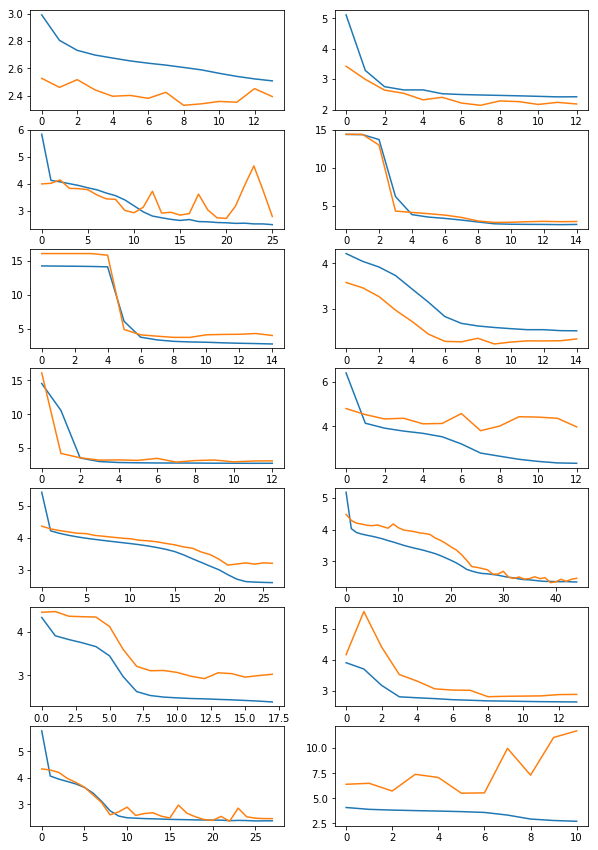

In [52]:
cv_metadata = u.cv_train_loso(
    gen_model, train_model,
    X_train, y_train, yi_train
)
u.cv_plot(cv_metadata)
cv_report = u.cv_report(cv_metadata)
cv_report

### Final model training

2.3801740823447726

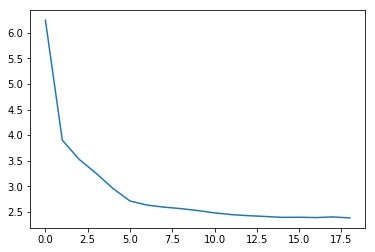

In [53]:
model = gen_model()
final_epochs = int(cv_report["epochs"][-1])
final_history = train_model(model, (X_train, y_train), None, epochs=final_epochs)
final_loss = final_history.history["loss"][-1]
plt.plot(final_history.history["loss"])
final_loss

### Evaluation

In [54]:
eval_df = {
    "region": [],
    "score": []
}

for region in tqdm(REGIONS):
    y_test, Xs_test, yi_test = target.get_testing_data(
        ACTUAL_DL, COMPONENTS, region, TEST_SPLIT_THRESH
    )
    
    X_test = udists.get_merged_features(
        Xs_test, 
        [partial(udists.dist_mean, bins=target.bins),
         partial(udists.dist_std, bins=target.bins)]
    )
    output = udists.mdn_params_to_dists(model.predict(X_test), bins=target.bins)
    y_one_hot = udists.actual_to_one_hot(y_test, bins=target.bins)
    
    eval_df["region"].append(region if region is not None else "all")
    eval_df["score"].append(losses.mean_cat_cross(y_one_hot, output))

eval_df = pd.DataFrame(eval_df)

# Save results
output_dir = u.ensure_dir(f"../results/{EXP_NAME}/{target.name}")
u.save_exp_summary(model, cv_report, {
    "loss": final_loss,
    "epochs": final_epochs    
}, f"{output_dir}/mdn_summary.txt")
eval_df.to_csv(f"{output_dir}/mdn.csv")
eval_df

100%|██████████| 12/12 [00:34<00:00,  3.07s/it]


,region,score
0,nat,2.4511372670087463
1,hhs1,2.3789536570331955
2,hhs2,3.171148554811377
3,hhs3,2.193247059816328
4,hhs4,2.409480340085049
5,hhs5,2.2607474817053257
6,hhs6,2.1410340462743425
7,hhs7,2.1301590169324913
8,hhs8,2.1916181265639048
9,hhs9,2.6425004729118955
